In [1]:
# Importing necessary libraries 

import numpy as np 
import pandas as pd 
import os 
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from sklearn.metrics import classification_report 
from PIL import Image
import sys
import glob
sys.path.append('/kaggle/input/stainnet')
from models import StainNet, ResnetGenerator
from tqdm.notebook import tqdm
os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = pow(2,60).__str__() # CV_IO_MAX_IMAGE_PIXELS
os.environ["CV_IO_MAX_IMAGE_PIXELS"] = pow(2,60).__str__() 
import cv2
from tqdm import tqdm 
import random 

In [2]:
# Function to get list of IDs for each class 

def get_IDs_for_label(df, label): 
    
    new_df = df[df['Label'] == label] 
    ids = new_df['Image'].to_list() 
    return ids 

train_df = pd.read_csv('/kaggle/input/aic2024/AIC 2024/AIC 2024/Train.csv') 
mitosis_train_ids = get_IDs_for_label(train_df, 'Mitosis') 
normal_train_ids = get_IDs_for_label(train_df, 'Normal') 

In [3]:
# Storing final mitosis paths & normal paths 

final_mitosis_paths = [] 
final_normal_paths = [] 

dir_ = '/kaggle/input/aic2024/NormalisedImages/Normalized Training Images/' 

# Total mitosis original images = 89 (IDs on 0-88th indexes) 
# image 0: 0, 89, 90, 91 
# image 1: 1, 92, 93, 94 
# image 2: 2, 95, 96, 97 
# image 3: 3, 98, 99, 100 

for i in range(0, 89): 
    
    final_mitosis_paths.append(dir_ + str(mitosis_train_ids[i]) + '.jpg') 
    final_mitosis_paths.append(dir_ + str(mitosis_train_ids[(i * 3) + 89]) + '.jpg') 
    final_mitosis_paths.append(dir_ + str(mitosis_train_ids[(i * 3) + 90]) + '.jpg') 
    final_mitosis_paths.append(dir_ + str(mitosis_train_ids[(i * 3) + 91]) + '.jpg') 

for i in range(0, 137): 
    
    final_normal_paths.append(dir_ + str(normal_train_ids[i]) + '.jpg') 
    final_normal_paths.append(dir_ + str(normal_train_ids[(i * 2) + 137]) + '.jpg') 
    final_normal_paths.append(dir_ + str(normal_train_ids[(i * 2) + 138]) + '.jpg') 

In [4]:
print(len(final_normal_paths)) 
print(len(final_mitosis_paths)) 

411
356


In [5]:
# Generate a list of unique numbers (for image IDs) 
unique_mitosis_nums = random.sample(range(88), 88) 
unique_normal_nums = random.sample(range(135), 135) 

In [6]:
# train, validation, test split 

train_paths = [] 
val_paths = [] 
temp_test_paths = [] 
train_labels = [] 
val_labels = [] 
temp_test_labels = [] 

# train: 4x + 3y = 415 (x = 60, y = 80) -> (mitosis = 240, normal = 240, total = 480) 
# val: 4x + 3y = 100 (x = 13, y = 27) -> (mitosis = 52, normal = 81, total = 133) 
# test: 4x + 3y = 108 (x = 15, y = 28) -> (mitosis = 60, normal = 84, total = 144) 

train_mitosis_indexes = unique_mitosis_nums[0:60] 
train_normal_indexes = unique_normal_nums[0:80] 
val_mitosis_indexes = unique_mitosis_nums[60:73] 
val_normal_indexes = unique_normal_nums[80:107] 
test_mitosis_indexes = unique_mitosis_nums[73:88] 
test_normal_indexes = unique_normal_nums[107:135] 

i = 0 
j = 0 
while i < 60 or j < 80: 
    if i < 60: 
        train_paths.extend(final_mitosis_paths[4 * train_mitosis_indexes[i]: (4 * train_mitosis_indexes[i]) + 4]) 
        train_labels.extend([1] * 4) 
        i += 1 
    if j < 80: 
        train_paths.extend(final_normal_paths[3 * train_normal_indexes[j]: (3 * train_normal_indexes[j]) + 3]) 
        train_labels.extend([0] * 3) 
        j += 1 
        

i = 0 
j = 0 
while i < 13 or j < 27: 
    if i < 60: 
        train_paths.extend(final_mitosis_paths[4 * train_mitosis_indexes[i]: (4 * train_mitosis_indexes[i]) + 4]) 
        train_labels.extend([1] * 4) 
        i += 1 
    if j < 80: 
        train_paths.extend(final_normal_paths[3 * train_normal_indexes[j]: (3 * train_normal_indexes[j]) + 3]) 
        train_labels.extend([0] * 3) 
        j += 1 

        
i = 0 
j = 0 
while i < 15 or j < 28: 
    if i < 15: 
        temp_test_paths.extend(final_mitosis_paths[4 * test_mitosis_indexes[i]: (4 * test_mitosis_indexes[i]) + 1]) 
        temp_test_labels.extend([1] * 1) 
        i += 1 
    if j < 28: 
        temp_test_paths.extend(final_normal_paths[3 * test_normal_indexes[j]: (3 * test_normal_indexes[j]) + 1]) 
        temp_test_labels.extend([0] * 1) 
        j += 1 

i = 0 
j = 0 
while i < 15 or j < 28: 
    if i < 15: 
        val_paths.extend(final_mitosis_paths[4 * test_mitosis_indexes[i]: (4 * test_mitosis_indexes[i]) + 4]) 
        val_labels.extend([1] * 4) 
        i += 1 
    if j < 28: 
        val_paths.extend(final_normal_paths[3 * test_normal_indexes[j]: (3 * test_normal_indexes[j]) + 3]) 
        val_labels.extend([0] * 3) 
        j += 1 

In [7]:
# Storing image paths for the test set 

test_df = pd.read_csv('/kaggle/input/aic2024/AIC 2024/AIC 2024/Test.csv') 
test_ids = test_df['Image'].to_list() 

dir_ = '/kaggle/input/aic2024/NormalisedImages/Normalized Test Images/' 
test_paths = [] 

for id in test_ids: 
    test_paths.append(dir_ + str(id) + '.jpg') 

dummy_test_labels = [1] * 57 

In [8]:
print(len(train_paths)) 
print(len(train_labels)) 
print(len(val_paths)) 
print(len(val_labels)) 
print(len(temp_test_paths)) 
print(len(temp_test_labels)) 
print(len(test_paths)) 
print(len(dummy_test_labels)) 

669
669
144
144
43
43
57
57


<BarContainer object of 2 artists>

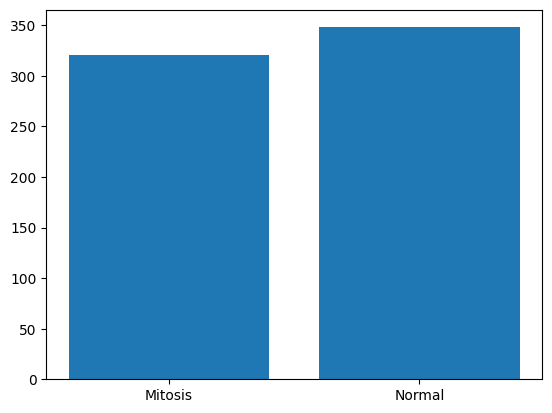

In [9]:
# Train 

plt.bar(['Mitosis', 'Normal'], [train_labels.count(0), train_labels.count(1)]) 

<BarContainer object of 2 artists>

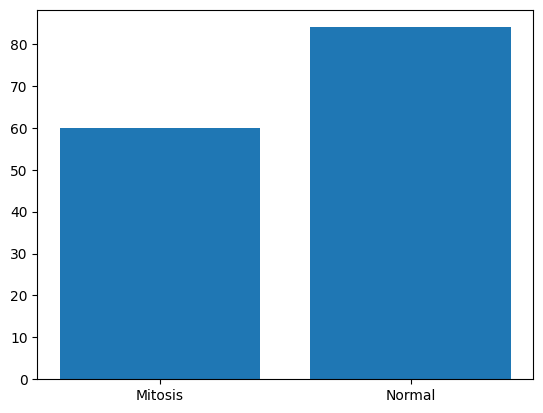

In [10]:
# Validation 

plt.bar(['Mitosis', 'Normal'], [val_labels.count(1), val_labels.count(0)]) 

<BarContainer object of 2 artists>

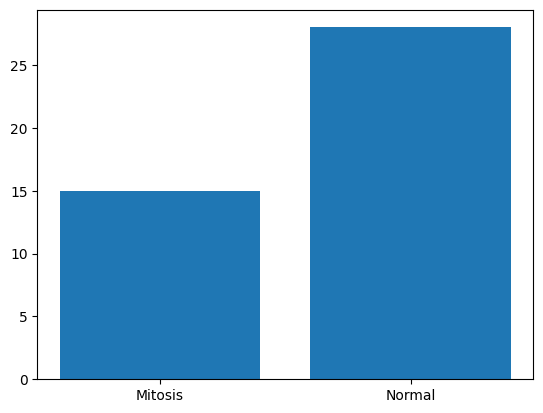

In [11]:
# Testing 

plt.bar(['Mitosis', 'Normal'], [temp_test_labels.count(1), temp_test_labels.count(0)]) 

**DATASETS & DATA GENERATORS** 

In [12]:
def normalize_patch(patch_path):
   # preparation for StainNet
    model_Net = StainNet().cuda()
    model_Net.load_state_dict(torch.load("/kaggle/input/stainnet/checkpoints/aligned_histopathology_dataset/StainNet-Public_layer3_ch32.pth"))
    model_Net.eval()

    def norm(image):
        image = np.array(image).astype(np.float32)
        image = image.transpose((2, 0, 1))
        image = ((image / 255) - 0.5) / 0.5
        image=image[np.newaxis, ...]
        image=torch.from_numpy(image)
        return image
    
    def un_norm(image):
        image = image.cpu().detach().numpy()[0]
        image = ((image * 0.5 + 0.5) * 255).astype(np.uint8).transpose((1,2,0))
        return image

    def stain_normalize(source, verbose=False):
        with torch.no_grad():
            img_net=model_Net(norm(source).cuda())
            img_net=un_norm(img_net)
            if verbose: plt.imshow(img_net); plt.show()
            return img_net
        
    img = Image.open(patch_path).convert("RGB")

    norm_img = stain_normalize(img)
    norm_img = np.array(norm_img)
    
    return norm_img 

In [13]:
# Custom Dataset 

from torchvision.io import read_image
from PIL import Image 

class CustomDataset(Dataset):
    def __init__(self, img_paths, labels, transform=None):
        self.image_paths = img_paths 
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = read_image(img_path)  # Use torchvision's read_image to load the image
        img = img[:, 0:3023, 504:3527] 
        img = Image.fromarray(img.permute(1, 2, 0).numpy())  # Convert to PIL Image
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label 

In [14]:
# Create instances of custom datasets 

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images
    transforms.ToTensor()           # Convert to tensor
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomRotation([90, 180]),
    transforms.ToTensor()           # Convert to tensor
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

train_dataset = CustomDataset(train_paths, train_labels, transform=transform_train) 
valid_dataset = CustomDataset(val_paths, val_labels, transform=transform) 
test_dataset_for_checking = CustomDataset(temp_test_paths, temp_test_labels, transform=transform) 
test_dataset = CustomDataset(test_paths, dummy_test_labels, transform=transform) 

In [15]:
batch_size = 32 

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers = 2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers = 2)
test_loader_val = DataLoader(test_dataset_for_checking, batch_size=batch_size, shuffle=False, num_workers = 2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers = 2)

**PIPELINE** 

In [16]:
pip install pytorch_accelerated 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 13.5 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.1
    Uninstalling tqdm-4.66.1:
      Successfully uninstalled tqdm-4.66.1
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.26.1
    Uninstalling accelerate-0.26.1:
      Successfully uninstalled accelerate-0.26.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 2023.128.151533 requires jupyterlab~=3.6.0, but you have jupyterlab 4.0.11 which is incompatible.
fitter 1.7.0 requires tqdm<5.0.0,>=4.65.1, but you have tqdm 4.64.1 which is incompatible.
momepy 0.7.0 requires shapely>=2, but you have shapely 1.8.5

In [17]:
import argparse
from pathlib import Path

import timm
import timm.data
import timm.loss
import timm.optim
import timm.utils
import torch
import torchmetrics
from timm.scheduler import CosineLRScheduler
from torch.nn import functional as F

from pytorch_accelerated.callbacks import SaveBestModelCallback
from pytorch_accelerated.trainer import Trainer, DEFAULT_CALLBACKS

2024-02-16 16:12:10.810496: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-16 16:12:10.810591: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-16 16:12:10.973970: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [18]:
pos_weight = torch.tensor([1.2])
pos_weight = pos_weight.to('cuda') 

In [19]:
import torchvision.models as models

class VGG16_bn(nn.Module):
    def __init__(self,num_classes):
        #define necessary layers
        super().__init__()
        self.num_classes = num_classes 
        self.model = models.vgg16_bn(weights=True) 

        # Unfreeze model weights
        for param in self.model.parameters():
            param.requires_grad = True
            
        self.model.fc = nn.Linear(in_features=2048, out_features=1000)
        self.flaten = nn.Flatten() 
        self.fc1 = nn.Linear(1000, out_features=256)
        self.fc2 = nn.Linear(256, out_features=64)
        self.fc3 = nn.Linear(64, out_features=num_classes)
        
        self.activation = nn.ReLU() 
        self.model.fc = nn.Linear(in_features=2048, out_features=1000)
        self.flaten = nn.Flatten()
        self.fc1 = nn.Linear(1000, out_features=512)
        self.bn1=nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, out_features=256)
        self.bn2=nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, out_features=128)
        self.bn3=nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, out_features=64)
        self.bn4=nn.BatchNorm1d(64)
        self.fc5 = nn.Linear(64, out_features=32)
        self.bn5=nn.BatchNorm1d(32)
        self.fc6 = nn.Linear(32, out_features=num_classes)
        
        self.dropout = nn.Dropout(0.3) 
        
    def forward(self,X):
        #define forward pass here
        X = self.model(X)
        X = self.flaten(X)
        
        X = self.fc1(X)
        X = self.bn1(X)
        X = self.activation(X)
        X = self.dropout(X)
        
        X = self.fc2(X)
        X = self.bn2(X)
        X = self.activation(X)
        X = self.dropout(X)
        
        X = self.fc3(X)
        X = self.bn3(X)
        X = self.activation(X)
        X = self.dropout(X)
        
        X = self.fc4(X)
        X = self.bn4(X)
        X = self.activation(X)
        #X = self.dropout(X)
        
        X = self.fc5(X)
        X = self.bn5(X)
        X = self.activation(X)
        #X = self.dropout(X)
        
        X = self.fc6(X)
        return X 
    
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight) 
    
model = VGG16_bn(1)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:03<00:00, 174MB/s]


In [20]:
# Check if GPU is available 

if torch.cuda.is_available():
    model = model.to('cuda')
    print('available')

#criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=0.00001)

available


In [21]:
#print(model) 

In [22]:
!export CUDA_LAUNCH_BLOCKING=1

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Initialize empty lists to store loss and accuracy for training and validation
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
roc_values_train = []
roc_values_val = []

In [24]:
# Training loop 

num_epochs = 30 # Adjust as needed
for epoch in range(num_epochs):
    
    model.train()
    y_true_train = []
    y_scores_train = []
    train_loss = 0
    correct = 0
    total = 0
    
    for images, labels in tqdm(train_loader):
        # Move data to GPU if available
        images = images.to('cuda')
        labels = labels.to('cuda')
        optimizer.zero_grad()
        outputs = model(images)

        loss = model.loss_fn(outputs.squeeze(-1), labels.float())
        out_probs = F.sigmoid(outputs)
        predicted = (out_probs>=0.4).long().squeeze(-1)
        #loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item() # L+=l.item()
        predicted = (out_probs>=0.4).long().squeeze(-1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true_train.extend(labels.cpu().detach().numpy())
        y_scores_train.extend(out_probs.cpu().detach().numpy())
    

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100 * correct / total) 
    
    # roc auc logic
    fpr_train, tpr_train, _ = roc_curve(y_true_train, y_scores_train) # pass sigmoid here
    roc_auc_train = auc(fpr_train, tpr_train)
    roc_values_train.append(roc_auc_train)
    
    # Plot ROC curve for the training set
   
    # Validate your model after each epoch if needed
    model.eval()
    valid_loss = 0
    correct = 0
    total = 0
    y_true_val=[]
    y_scores_val=[]
    with torch.no_grad():
        for images, labels in tqdm(valid_loader):
            # Move data to GPU if available 
            images = images.to('cuda')
            labels = labels.to('cuda')
            outputs = model(images)
            
            loss = model.loss_fn(outputs.squeeze(-1), labels.float())
            valid_loss += loss.item() # L+=l.item()
            out_probs = F.sigmoid(outputs)
            predicted = (out_probs>=0.4).long().squeeze(-1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            y_true_val.extend(labels.cpu().detach().numpy())
            y_scores_val.extend(out_probs.cpu().detach().numpy())
    
    report = classification_report(np.array(y_true_val).astype('long'), np.round(np.array(y_scores_val).squeeze(-1)).astype('long'),zero_division = 0)
    print("Classification Report (Validation)\n",report)
    
    valid_losses.append(valid_loss / len(valid_loader))
    valid_accuracies.append(100 * correct / total)
    # roc auc logic
    fpr_val, tpr_val, _ = roc_curve(y_true_val, y_scores_val)
    roc_auc_val = auc(fpr_val, tpr_val)
    roc_values_val.append(roc_auc_val)
     
    print(f'Epoch {epoch + 1}, Train Accuracy: {train_accuracies[-1]:.2f}%, Train Loss: {train_losses[-1]:.2f}%, Train ROC-AUC: {roc_auc_train:.2f}%, Val Accuracy: {valid_accuracies[-1]:.2f}%, Val Loss: {valid_losses[-1]:.2f}%, Val ROC-AUC: {roc_auc_val:.2f}%')

100%|██████████| 5/5 [00:22<00:00,  4.56s/it]


Classification Report (Validation)
               precision    recall  f1-score   support

           0       0.57      0.94      0.71        84
           1       0.17      0.02      0.03        60

    accuracy                           0.56       144
   macro avg       0.37      0.48      0.37       144
weighted avg       0.40      0.56      0.43       144

Epoch 1, Train Accuracy: 50.52%, Train Loss: 0.77%, Train ROC-AUC: 0.53%, Val Accuracy: 41.67%, Val Loss: 0.74%, Val ROC-AUC: 0.40%


100%|██████████| 5/5 [00:23<00:00,  4.76s/it]


Classification Report (Validation)
               precision    recall  f1-score   support

           0       0.59      0.96      0.73        84
           1       0.57      0.07      0.12        60

    accuracy                           0.59       144
   macro avg       0.58      0.52      0.43       144
weighted avg       0.58      0.59      0.48       144

Epoch 2, Train Accuracy: 53.96%, Train Loss: 0.75%, Train ROC-AUC: 0.60%, Val Accuracy: 44.44%, Val Loss: 0.72%, Val ROC-AUC: 0.61%


100%|██████████| 5/5 [00:23<00:00,  4.74s/it]


Classification Report (Validation)
               precision    recall  f1-score   support

           0       0.62      0.94      0.75        84
           1       0.71      0.20      0.31        60

    accuracy                           0.63       144
   macro avg       0.66      0.57      0.53       144
weighted avg       0.66      0.63      0.57       144

Epoch 3, Train Accuracy: 54.11%, Train Loss: 0.74%, Train ROC-AUC: 0.63%, Val Accuracy: 50.69%, Val Loss: 0.70%, Val ROC-AUC: 0.75%


100%|██████████| 5/5 [00:21<00:00,  4.28s/it]


Classification Report (Validation)
               precision    recall  f1-score   support

           0       0.69      0.95      0.80        84
           1       0.86      0.40      0.55        60

    accuracy                           0.72       144
   macro avg       0.77      0.68      0.67       144
weighted avg       0.76      0.72      0.69       144

Epoch 4, Train Accuracy: 56.65%, Train Loss: 0.72%, Train ROC-AUC: 0.69%, Val Accuracy: 55.56%, Val Loss: 0.68%, Val ROC-AUC: 0.80%


100%|██████████| 5/5 [00:21<00:00,  4.33s/it]


Classification Report (Validation)
               precision    recall  f1-score   support

           0       0.70      0.95      0.80        84
           1       0.86      0.42      0.56        60

    accuracy                           0.73       144
   macro avg       0.78      0.68      0.68       144
weighted avg       0.76      0.73      0.70       144

Epoch 5, Train Accuracy: 59.04%, Train Loss: 0.70%, Train ROC-AUC: 0.73%, Val Accuracy: 56.25%, Val Loss: 0.68%, Val ROC-AUC: 0.81%


100%|██████████| 5/5 [00:23<00:00,  4.68s/it]


Classification Report (Validation)
               precision    recall  f1-score   support

           0       0.70      0.96      0.81        84
           1       0.90      0.43      0.58        60

    accuracy                           0.74       144
   macro avg       0.80      0.70      0.70       144
weighted avg       0.78      0.74      0.72       144

Epoch 6, Train Accuracy: 61.73%, Train Loss: 0.68%, Train ROC-AUC: 0.77%, Val Accuracy: 58.33%, Val Loss: 0.67%, Val ROC-AUC: 0.84%


100%|██████████| 5/5 [00:21<00:00,  4.36s/it]


Classification Report (Validation)
               precision    recall  f1-score   support

           0       0.78      0.95      0.86        84
           1       0.90      0.62      0.73        60

    accuracy                           0.81       144
   macro avg       0.84      0.78      0.79       144
weighted avg       0.83      0.81      0.80       144

Epoch 7, Train Accuracy: 60.84%, Train Loss: 0.68%, Train ROC-AUC: 0.77%, Val Accuracy: 59.72%, Val Loss: 0.65%, Val ROC-AUC: 0.86%


100%|██████████| 5/5 [00:21<00:00,  4.34s/it]


Classification Report (Validation)
               precision    recall  f1-score   support

           0       0.77      0.95      0.85        84
           1       0.90      0.60      0.72        60

    accuracy                           0.81       144
   macro avg       0.83      0.78      0.79       144
weighted avg       0.82      0.81      0.80       144

Epoch 8, Train Accuracy: 63.23%, Train Loss: 0.67%, Train ROC-AUC: 0.80%, Val Accuracy: 66.67%, Val Loss: 0.64%, Val ROC-AUC: 0.87%


100%|██████████| 5/5 [00:22<00:00,  4.56s/it]


Classification Report (Validation)
               precision    recall  f1-score   support

           0       0.78      0.95      0.86        84
           1       0.90      0.63      0.75        60

    accuracy                           0.82       144
   macro avg       0.84      0.79      0.80       144
weighted avg       0.83      0.82      0.81       144

Epoch 9, Train Accuracy: 66.22%, Train Loss: 0.65%, Train ROC-AUC: 0.83%, Val Accuracy: 69.44%, Val Loss: 0.63%, Val ROC-AUC: 0.89%


100%|██████████| 5/5 [00:21<00:00,  4.23s/it]


Classification Report (Validation)
               precision    recall  f1-score   support

           0       0.81      0.94      0.87        84
           1       0.89      0.70      0.79        60

    accuracy                           0.84       144
   macro avg       0.85      0.82      0.83       144
weighted avg       0.85      0.84      0.84       144

Epoch 10, Train Accuracy: 66.82%, Train Loss: 0.64%, Train ROC-AUC: 0.84%, Val Accuracy: 69.44%, Val Loss: 0.62%, Val ROC-AUC: 0.89%


100%|██████████| 5/5 [00:21<00:00,  4.39s/it]


Classification Report (Validation)
               precision    recall  f1-score   support

           0       0.82      0.95      0.88        84
           1       0.91      0.72      0.80        60

    accuracy                           0.85       144
   macro avg       0.87      0.83      0.84       144
weighted avg       0.86      0.85      0.85       144

Epoch 11, Train Accuracy: 67.56%, Train Loss: 0.62%, Train ROC-AUC: 0.87%, Val Accuracy: 71.53%, Val Loss: 0.62%, Val ROC-AUC: 0.90%


100%|██████████| 5/5 [00:22<00:00,  4.42s/it]


Classification Report (Validation)
               precision    recall  f1-score   support

           0       0.84      0.93      0.88        84
           1       0.88      0.75      0.81        60

    accuracy                           0.85       144
   macro avg       0.86      0.84      0.85       144
weighted avg       0.86      0.85      0.85       144

Epoch 12, Train Accuracy: 70.70%, Train Loss: 0.61%, Train ROC-AUC: 0.88%, Val Accuracy: 68.06%, Val Loss: 0.62%, Val ROC-AUC: 0.90%


100%|██████████| 5/5 [00:22<00:00,  4.50s/it]


Classification Report (Validation)
               precision    recall  f1-score   support

           0       0.82      0.93      0.87        84
           1       0.88      0.72      0.79        60

    accuracy                           0.84       144
   macro avg       0.85      0.82      0.83       144
weighted avg       0.84      0.84      0.84       144

Epoch 13, Train Accuracy: 68.91%, Train Loss: 0.61%, Train ROC-AUC: 0.88%, Val Accuracy: 68.06%, Val Loss: 0.62%, Val ROC-AUC: 0.88%


100%|██████████| 5/5 [00:24<00:00,  4.92s/it]


Classification Report (Validation)
               precision    recall  f1-score   support

           0       0.83      0.93      0.88        84
           1       0.88      0.73      0.80        60

    accuracy                           0.85       144
   macro avg       0.85      0.83      0.84       144
weighted avg       0.85      0.85      0.84       144

Epoch 14, Train Accuracy: 75.19%, Train Loss: 0.58%, Train ROC-AUC: 0.91%, Val Accuracy: 68.06%, Val Loss: 0.61%, Val ROC-AUC: 0.88%


100%|██████████| 5/5 [00:24<00:00,  4.84s/it]


Classification Report (Validation)
               precision    recall  f1-score   support

           0       0.82      0.93      0.87        84
           1       0.88      0.72      0.79        60

    accuracy                           0.84       144
   macro avg       0.85      0.82      0.83       144
weighted avg       0.84      0.84      0.84       144

Epoch 15, Train Accuracy: 72.20%, Train Loss: 0.59%, Train ROC-AUC: 0.89%, Val Accuracy: 71.53%, Val Loss: 0.61%, Val ROC-AUC: 0.88%


100%|██████████| 5/5 [00:23<00:00,  4.69s/it]


Classification Report (Validation)
               precision    recall  f1-score   support

           0       0.81      0.93      0.87        84
           1       0.88      0.70      0.78        60

    accuracy                           0.83       144
   macro avg       0.84      0.81      0.82       144
weighted avg       0.84      0.83      0.83       144

Epoch 16, Train Accuracy: 74.59%, Train Loss: 0.57%, Train ROC-AUC: 0.92%, Val Accuracy: 70.83%, Val Loss: 0.61%, Val ROC-AUC: 0.87%


100%|██████████| 5/5 [00:22<00:00,  4.43s/it]


Classification Report (Validation)
               precision    recall  f1-score   support

           0       0.83      0.93      0.88        84
           1       0.88      0.73      0.80        60

    accuracy                           0.85       144
   macro avg       0.85      0.83      0.84       144
weighted avg       0.85      0.85      0.84       144

Epoch 17, Train Accuracy: 74.14%, Train Loss: 0.57%, Train ROC-AUC: 0.91%, Val Accuracy: 69.44%, Val Loss: 0.60%, Val ROC-AUC: 0.88%


100%|██████████| 5/5 [00:22<00:00,  4.40s/it]


Classification Report (Validation)
               precision    recall  f1-score   support

           0       0.81      0.94      0.87        84
           1       0.89      0.68      0.77        60

    accuracy                           0.83       144
   macro avg       0.85      0.81      0.82       144
weighted avg       0.84      0.83      0.83       144

Epoch 18, Train Accuracy: 77.28%, Train Loss: 0.56%, Train ROC-AUC: 0.93%, Val Accuracy: 71.53%, Val Loss: 0.61%, Val ROC-AUC: 0.87%


100%|██████████| 5/5 [00:23<00:00,  4.67s/it]


Classification Report (Validation)
               precision    recall  f1-score   support

           0       0.79      0.94      0.86        84
           1       0.89      0.65      0.75        60

    accuracy                           0.82       144
   macro avg       0.84      0.80      0.80       144
weighted avg       0.83      0.82      0.81       144

Epoch 19, Train Accuracy: 77.73%, Train Loss: 0.55%, Train ROC-AUC: 0.94%, Val Accuracy: 72.92%, Val Loss: 0.61%, Val ROC-AUC: 0.88%


100%|██████████| 5/5 [00:21<00:00,  4.35s/it]


Classification Report (Validation)
               precision    recall  f1-score   support

           0       0.80      0.94      0.86        84
           1       0.89      0.67      0.76        60

    accuracy                           0.83       144
   macro avg       0.84      0.80      0.81       144
weighted avg       0.84      0.83      0.82       144

Epoch 20, Train Accuracy: 77.43%, Train Loss: 0.55%, Train ROC-AUC: 0.93%, Val Accuracy: 72.92%, Val Loss: 0.61%, Val ROC-AUC: 0.88%


100%|██████████| 5/5 [00:22<00:00,  4.54s/it]


Classification Report (Validation)
               precision    recall  f1-score   support

           0       0.78      0.94      0.85        84
           1       0.88      0.63      0.74        60

    accuracy                           0.81       144
   macro avg       0.83      0.79      0.80       144
weighted avg       0.82      0.81      0.81       144

Epoch 21, Train Accuracy: 80.57%, Train Loss: 0.54%, Train ROC-AUC: 0.94%, Val Accuracy: 72.92%, Val Loss: 0.62%, Val ROC-AUC: 0.87%


100%|██████████| 5/5 [00:22<00:00,  4.50s/it]


Classification Report (Validation)
               precision    recall  f1-score   support

           0       0.78      0.94      0.85        84
           1       0.88      0.63      0.74        60

    accuracy                           0.81       144
   macro avg       0.83      0.79      0.80       144
weighted avg       0.82      0.81      0.81       144

Epoch 22, Train Accuracy: 79.82%, Train Loss: 0.53%, Train ROC-AUC: 0.94%, Val Accuracy: 72.92%, Val Loss: 0.61%, Val ROC-AUC: 0.87%


100%|██████████| 5/5 [00:22<00:00,  4.41s/it]


Classification Report (Validation)
               precision    recall  f1-score   support

           0       0.79      0.94      0.86        84
           1       0.89      0.65      0.75        60

    accuracy                           0.82       144
   macro avg       0.84      0.80      0.80       144
weighted avg       0.83      0.82      0.81       144

Epoch 23, Train Accuracy: 79.82%, Train Loss: 0.53%, Train ROC-AUC: 0.94%, Val Accuracy: 75.00%, Val Loss: 0.60%, Val ROC-AUC: 0.87%


100%|██████████| 5/5 [00:23<00:00,  4.62s/it]


Classification Report (Validation)
               precision    recall  f1-score   support

           0       0.82      0.94      0.88        84
           1       0.90      0.72      0.80        60

    accuracy                           0.85       144
   macro avg       0.86      0.83      0.84       144
weighted avg       0.85      0.85      0.84       144

Epoch 24, Train Accuracy: 84.45%, Train Loss: 0.51%, Train ROC-AUC: 0.95%, Val Accuracy: 72.22%, Val Loss: 0.61%, Val ROC-AUC: 0.87%


100%|██████████| 5/5 [00:21<00:00,  4.30s/it]


Classification Report (Validation)
               precision    recall  f1-score   support

           0       0.81      0.94      0.87        84
           1       0.89      0.70      0.79        60

    accuracy                           0.84       144
   macro avg       0.85      0.82      0.83       144
weighted avg       0.85      0.84      0.84       144

Epoch 25, Train Accuracy: 82.51%, Train Loss: 0.52%, Train ROC-AUC: 0.95%, Val Accuracy: 72.92%, Val Loss: 0.60%, Val ROC-AUC: 0.87%


100%|██████████| 5/5 [00:23<00:00,  4.78s/it]


Classification Report (Validation)
               precision    recall  f1-score   support

           0       0.83      0.93      0.88        84
           1       0.88      0.73      0.80        60

    accuracy                           0.85       144
   macro avg       0.85      0.83      0.84       144
weighted avg       0.85      0.85      0.84       144

Epoch 26, Train Accuracy: 82.81%, Train Loss: 0.50%, Train ROC-AUC: 0.96%, Val Accuracy: 72.22%, Val Loss: 0.59%, Val ROC-AUC: 0.88%


100%|██████████| 5/5 [00:21<00:00,  4.24s/it]


Classification Report (Validation)
               precision    recall  f1-score   support

           0       0.83      0.90      0.86        84
           1       0.85      0.73      0.79        60

    accuracy                           0.83       144
   macro avg       0.84      0.82      0.82       144
weighted avg       0.83      0.83      0.83       144

Epoch 27, Train Accuracy: 83.86%, Train Loss: 0.51%, Train ROC-AUC: 0.96%, Val Accuracy: 71.53%, Val Loss: 0.58%, Val ROC-AUC: 0.88%


100%|██████████| 5/5 [00:21<00:00,  4.37s/it]


Classification Report (Validation)
               precision    recall  f1-score   support

           0       0.82      0.94      0.88        84
           1       0.90      0.72      0.80        60

    accuracy                           0.85       144
   macro avg       0.86      0.83      0.84       144
weighted avg       0.85      0.85      0.84       144

Epoch 28, Train Accuracy: 84.90%, Train Loss: 0.49%, Train ROC-AUC: 0.96%, Val Accuracy: 72.22%, Val Loss: 0.58%, Val ROC-AUC: 0.87%


100%|██████████| 5/5 [00:21<00:00,  4.28s/it]


Classification Report (Validation)
               precision    recall  f1-score   support

           0       0.81      0.94      0.87        84
           1       0.89      0.70      0.79        60

    accuracy                           0.84       144
   macro avg       0.85      0.82      0.83       144
weighted avg       0.85      0.84      0.84       144

Epoch 29, Train Accuracy: 86.55%, Train Loss: 0.49%, Train ROC-AUC: 0.97%, Val Accuracy: 73.61%, Val Loss: 0.59%, Val ROC-AUC: 0.87%


100%|██████████| 5/5 [00:22<00:00,  4.43s/it]

Classification Report (Validation)
               precision    recall  f1-score   support

           0       0.79      0.94      0.86        84
           1       0.89      0.65      0.75        60

    accuracy                           0.82       144
   macro avg       0.84      0.80      0.80       144
weighted avg       0.83      0.82      0.81       144

Epoch 30, Train Accuracy: 85.65%, Train Loss: 0.48%, Train ROC-AUC: 0.97%, Val Accuracy: 75.00%, Val Loss: 0.59%, Val ROC-AUC: 0.87%


In [25]:
outputs

tensor([[-0.0725],
        [-1.2672],
        [-0.9106],
        [-1.3416],
        [-0.0721],
        [ 0.0587],
        [-0.0451],
        [-0.1958],
        [-0.0284],
        [ 0.0685],
        [-0.2579],
        [-0.3743],
        [-0.5639],
        [-1.0893],
        [-0.9893],
        [-1.0896]], device='cuda:0')

In [26]:
def display_training_curves(train_losses, valid_losses, train_accuracies, valid_accuracies, subplot):
    if subplot % 10 == 1:  # set up the subplots on the first call
        plt.subplots(figsize=(10, 10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(train_losses)
    ax.plot(valid_losses)
    ax.set_title('Model Loss')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.legend(['Train', 'Valid'])

    ax = plt.subplot(subplot + 1)
    ax.set_facecolor('#F8F8F8')
    ax.plot(train_accuracies)
    ax.plot(valid_accuracies)
    ax.set_title('Model Accuracy')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.legend(['Train', 'Valid'])

/tmp/ipykernel_27/881508614.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


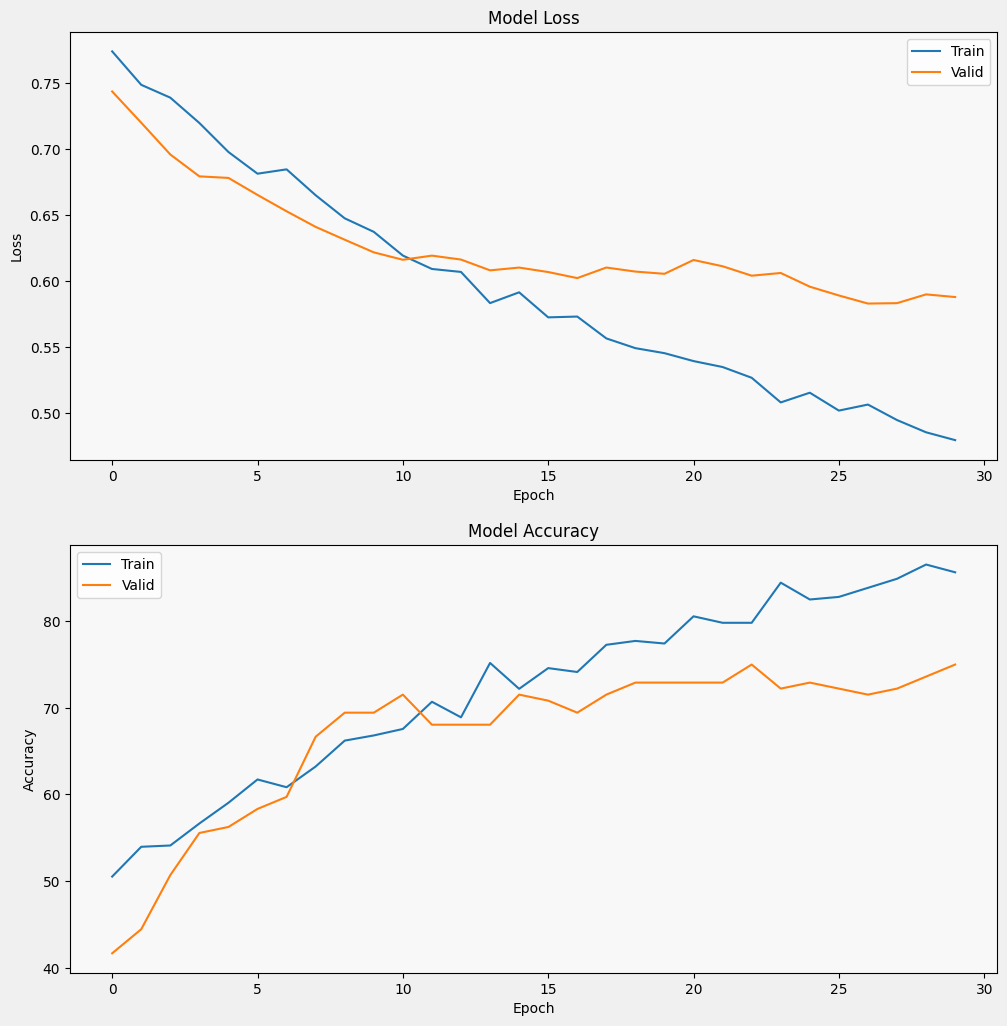

In [27]:
# Plot the training curves
display_training_curves(train_losses, valid_losses, train_accuracies, valid_accuracies, 211)

**TEMP TESTING** 

              precision    recall  f1-score   support

           0       0.86      0.68      0.76        28
           1       0.57      0.80      0.67        15

    accuracy                           0.72        43
   macro avg       0.72      0.74      0.71        43
weighted avg       0.76      0.72      0.73        43



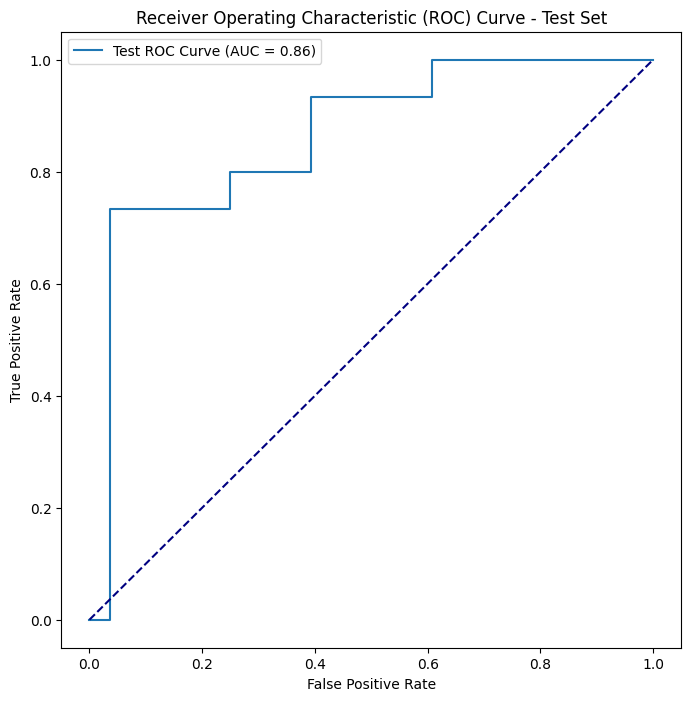

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


# Initialize lists to store true labels and predicted labels
true_labels = [] 
predicted_pos_probs = [] 
predicted_neg_probs = [] 
predicted_labels = [] 

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader_val:
        # Move data to GPU if available
        images = images.to('cuda')
        labels = labels.to('cuda')
        outputs = model(images) 
        outputs = F.sigmoid(outputs) 
        
        predicted = (outputs >= 0.4).long().squeeze(-1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Append true and predicted labels to the lists, along with probabilities 
        for i in range(len(outputs)):
            predicted_pos_probs.append(outputs[i].item())
            predicted_neg_probs.append(1 - outputs[i].item())
            true_labels.append(labels[i].item()) 
            predicted_labels.append(predicted[i].item())

# Calculate ROC and AUC for the test set
fpr_test, tpr_test, _ = roc_curve(true_labels, predicted_pos_probs)
roc_auc_test = auc(fpr_test, tpr_test)

# Classification Report 
classification_rep = classification_report(true_labels, predicted_labels)
print(classification_rep)

# Plot ROC curve for the test set
plt.figure(figsize=(8, 8))
plt.plot(fpr_test, tpr_test, label=f'Test ROC Curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Set')
plt.legend()
plt.show()

In [29]:
outputs

tensor([[0.4231],
        [0.3468],
        [0.1747],
        [0.2081],
        [0.3054],
        [0.4470],
        [0.2197],
        [0.4820],
        [0.4512],
        [0.4359],
        [0.2518]], device='cuda:0')

In [30]:
# calculating tp, fp, tn & fn 

tp = 0 
tn = 0 
fp = 0 
fn = 0 

for i in range(0, len(temp_test_labels)): 
    
    if true_labels[i] == 1 and predicted_labels[i] == 1: 
        tp = tp + 1 
    
    elif true_labels[i] == 0 and predicted_labels[i] == 1: 
        fp = fp + 1 
        
    elif true_labels[i] == 0 and predicted_labels[i] == 0: 
        tn = tn + 1 
    
    else: 
        fn = fn + 1 

print('True +:', tp) 
print('False -:', fn) 
print('True -:', tn) 
print('False +:', fp) 

True +: 12
False -: 3
True -: 19
False +: 9


In [31]:
# Calculating accuracy 
test_accuracy = (tp + tn) / (tp + fn + tn + fp) 
# Calculating precision 
precision = tp / (tp + fp) 
# Calculating recall 
recall = tp / (tp + fn) 
# Calculating F-1 score 
F1 = (2 * precision * recall) / (precision + recall) 

print('\nTest Accuracy =', test_accuracy) 
print('Precision =', precision) 
print('Recall =', recall) 
print('F-1 Score =', F1) 


Test Accuracy = 0.7209302325581395
Precision = 0.5714285714285714
Recall = 0.8
F-1 Score = 0.6666666666666666


/tmp/ipykernel_27/178049118.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', 'Predicted Negative', 'Predicted Positive'])
/tmp/ipykernel_27/178049118.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', 'Actual Negative', 'Actual Positive'])


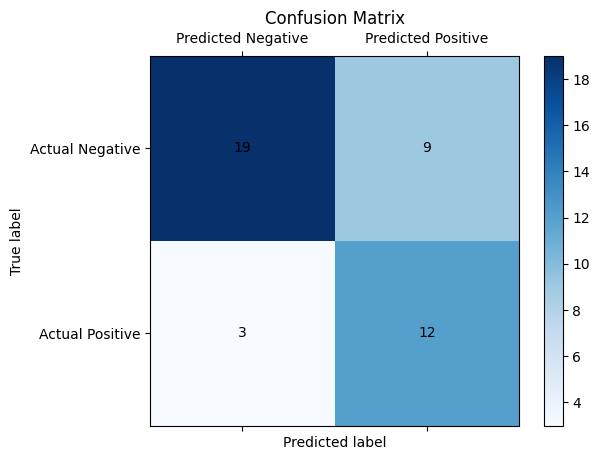

In [32]:
def make_confusion_matrix(true_positive, true_negative, false_positive, false_negative):
    confusion_matrix = [[true_negative, false_positive], [false_negative, true_positive]]
    # Plot the confusion matrix
    fig, ax = plt.subplots()
    cax = ax.matshow(confusion_matrix, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.colorbar(cax)
    ax.set_xticklabels(['', 'Predicted Negative', 'Predicted Positive'])
    ax.set_yticklabels(['', 'Actual Negative', 'Actual Positive'])
    for i in range(2):
        for j in range(2):
            ax.text(j, i, str(confusion_matrix[i][j]), va='center', ha='center', color='black')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show() 

make_confusion_matrix(tp, tn, fp, fn) 

**TESTING** 

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


# Initialize lists to store true labels and predicted labels
true_labels = [] 
predicted_labels = [] 

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        # Move data to GPU if available
        images = images.to('cuda')
        labels = labels.to('cuda')
        outputs = model(images) 
        outputs = F.sigmoid(outputs) 
        
        predicted = (outputs >= 0.5).long().squeeze(-1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Append true and predicted labels to the lists, along with probabilities 
        for i in range(len(outputs)):
            true_labels.append(labels[i].item()) 
            predicted_labels.append(predicted[i].item())


In [34]:
# Storing predictions in a list 

predictions = [] 

for label in predicted_labels: 
    if label == 0: 
        predictions.append('Normal') 
    else: 
        predictions.append('Mitosis') 

In [35]:
# Storing predictions in a dataframe 

submission = pd.DataFrame({ 
    'Image': test_ids, 
    'Label': predictions }) 

In [36]:
submission['Label'].value_counts() 

Label
Normal     42
Mitosis    15
Name: count, dtype: int64

In [37]:
# Saving csv file 

output_directory = '/kaggle/working/submission_file/' 

os.makedirs(output_directory) 

submission.to_csv(output_directory + 'TeamCode_submission_new.csv', index = False) 